In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, uniform, beta, bernoulli

/home/dgarrido/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels

# A.1 Simulating

Sampling the following unnormalized distribution
$\begin{align}
p(x) \propto2e^{-(x-2)^{2}}+e^{-|x|}+e^{-(x+2)^{2}}e^{-|x+2|}
\end{align}
$
, using Metropolis-Hastings with proposal $q(x^{'}|x_{i})=\mathcal{N}(x_{i}, \sigma^{2})$. Since the proposal is symmetric, the acceptance probability is given by $\alpha=\min\big(1, \frac{\tilde{p}(x')}{\tilde{p}(x_{i})}\big)$.

In [3]:
def p_bar(x):
    pdf = 2*np.exp(-(x-2)**2)+np.exp(-np.abs(x))
    pdf+=np.exp(-(x+2)**2)*np.exp(-np.abs(x+2))
    return pdf

def MetropolisHasting(sigma=1, n=5000, seed=0):
    # set seed
    np.random.seed(seed)
    # trace
    x = np.zeros(n+1)
    # init value
    x[0] = norm.rvs(0, sigma)
    for i in range(0,n):
        # sample x': x'~q(x'|x[i]) = Normal(x[i], sigma)
        x_ = np.random.normal(x[i], sigma)
        # compute acceptance probability
        # the term associated to q is omitted due that q is a symmetric proposal
        r = min(1, p_bar(x_)/p_bar(x[i]) )
        # sample u~sim U(0,1)
        u = uniform.rvs(0,1)
        # set new sample
        if r>u:
            x[i+1] = x_
        else:
            x[i+1] = x[i]
    return x[1:]

In [4]:
def plot_histogram(x, sigma, size):
    rows, cols = size
    x = x.reshape(rows, cols, -1)
    sigma = sigma.reshape(rows, cols)
    fig, axs = plt.subplots(2, 2, figsize=(16,9))
    for i in range(2):
        for j in range(2):
            sns.distplot(x[i,j], ax=axs[i,j])
            axs[i,j].spines['right'].set_visible(False)
            axs[i,j].spines['top'].set_visible(False)
            axs[i,j].set_xlim(-20,20)
            axs[i,j].set_xlabel(rf"$\sigma$={sigma[i,j]}")
    plt.show()
    return fig

In [5]:
# sampling
seed = 0
n = 5000
sigma = np.array([0.01, 0.1, 1, 10])
x = np.array([MetropolisHasting(sigma=s, n=n, seed=seed) for s in sigma])

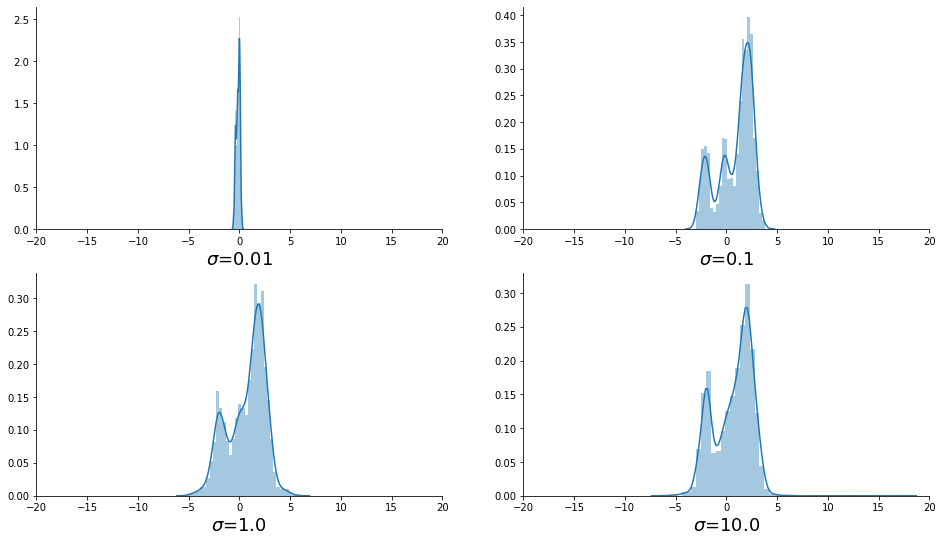

In [6]:
fig1 = plot_histogram(x, sigma, (2,2))

# A.2 Simulated Annealing

In [7]:
def temperature(n, C):
    T = np.zeros(n)
    T[0] = 1
    for i in range(0, n-1):
        T[i+1]=(C*np.log(i+1+T[0]))**-1
    return T

In [8]:
def SimulatedAnnealing(sigma=1, n=5000, seed=0):
    # set seed
    np.random.seed(seed)
    # trace
    x = np.zeros(n+1)
    # temperature
    T = np.zeros(n+1)
    # init values
    x[0] = norm.rvs(0, sigma)
    T[0] = 1
    C = 2
    for i in range(0,n):
        # sample x': x'~q(x'|x[i]) = Normal(x[i], sigma)
        x_ = np.random.normal(x[i], sigma)
        # compute acceptance probability
        # the term associated to q is omitted due that q is a symmetric proposal
        r = min(1, (p_bar(x_)/p_bar(x[i]))**(1/T[i]) )
        # sample u~sim U(0,1)
        u = uniform.rvs(0,1)
        # set new sample
        if r>u:
            x[i+1] = x_
        else:
            x[i+1] = x[i]
        # update temperature
        T[i+1]=(C*np.log(i+1+T[0]))**-1
    return x[1:]

In [9]:
# sampling
x = np.array([SimulatedAnnealing(sigma=s, n=n, seed=seed) for s in sigma])

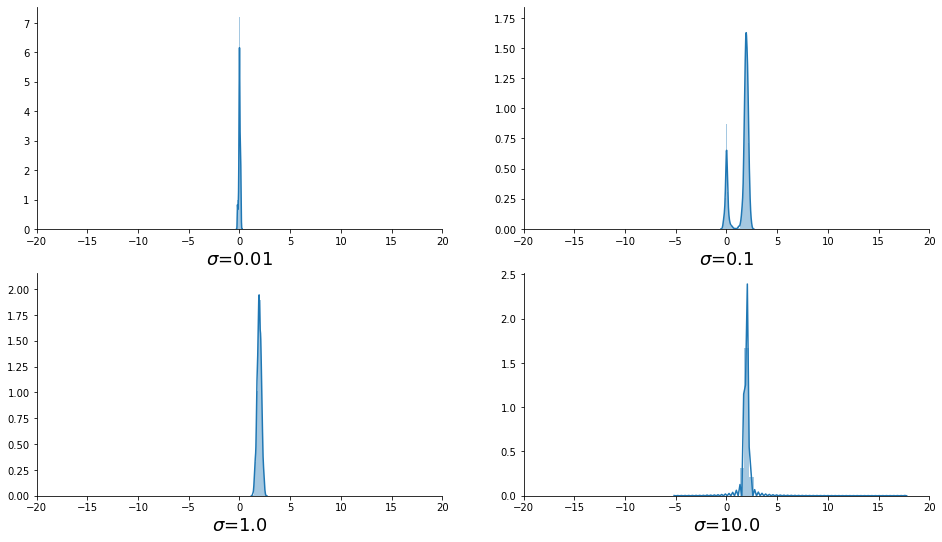

In [10]:
fig2 = plot_histogram(x, sigma, (2,2))

In [11]:
x.mean(axis=1)

array([0.00663812, 1.56923655, 1.94902959, 1.96850611])

# B. Gibbs Sampling

Consider the folliwing
\begin{align}
\mu_{0}, \mu_{1} &\sim \mathcal{N}(0,5)\\
\pi&\sim Beta(0.8,0.8)\\
Z_{1}, \ldots, Z_{100}|\mu, \pi &\sim Bernoulli(\pi)\\
X_{i} &\sim \mathcal{N}(\mu_{Z_{i}, 0.25}) 
\end{align}



In [12]:
def SamplingMixtureTwoNormal(n=100, seed=1234):
        np.random.seed(seed)
        mu = norm.rvs(loc=0, scale=5, size=2)
        pi = beta.rvs(a=0.8, b=0.8)
        z = bernoulli.rvs(p=pi, size=n)
        x = np.array([norm.rvs(mu[z[i]], 0.25) for i in range(n)])
        return mu, pi, z, x

In [13]:
# samplin mixture of two normal
mu, pi, z, x = SamplingMixtureTwoNormal(n=100, seed=1234)
print(f"mu_0={mu[0].round(3)}, mu_1={mu[1].round(3)}, pi={pi.round(3)}")

mu_0=2.357, mu_1=-5.955, pi=0.788


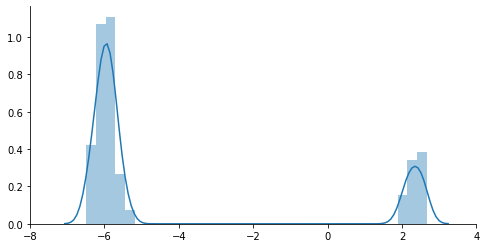

In [14]:
fig3, axs = plt.subplots(1, 1, figsize=(8,4))
sns.distplot(x, ax=axs)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.set_xlim(-8,4)
plt.show()

In [15]:
def GibbSampling(x, n=1000, seed=0):
    # set seed
    np.random.seed(seed)
    
    # init values
    N = len(x)
    mu = [x.mean(), x.mean()]
    pi = 0.5
    z = bernoulli.rvs(p=pi, size=N)
    
    # trace
    trace = {"mu":np.zeros((n,2)), "pi":np.zeros(n), "z":np.zeros((n,N))}
    
    for i in range(0, n):
        
        # sampling hidden variables
        for j in range(0,N):
            alpha0 = (1-pi)*norm.pdf(x[j], mu[0], 0.25)
            alpha1 = pi*norm.pdf(x[j], mu[1], 0.25)
            z[j]= bernoulli.rvs(p=alpha1/(alpha0+alpha1))
        
        # sampling weight
        N_1 = z.sum()
        N_0 = N-N_1
        pi = beta.rvs(a=0.8+N_1, b=0.8+N_0)
       
        # sampling means
        sigma_0 = (1/5**2+N_0/0.25**2)**(-1/2)
        sigma_1 = (1/5**2+N_1/0.25**2)**(-1/2)
        mu_0 = sigma_0**2*(x[z==0].sum()/0.25**2)
        mu_1 = sigma_1**2*(x[z==1].sum()/0.25**2)
        mu[0] = norm.rvs(mu_0, sigma_0)
        mu[1] = norm.rvs(mu_1, sigma_1)
        
        # update trace
        trace["mu"][i] = mu
        trace["pi"][i] = pi
        trace["z"][i] = z
    return trace

In [16]:
trace =  GibbSampling(x, n=100, seed=0)

In [17]:
trace["pi"].mean()

0.7702959404434625

In [18]:
trace["mu"].mean(axis=0)

array([ 2.27471038, -5.95417496])

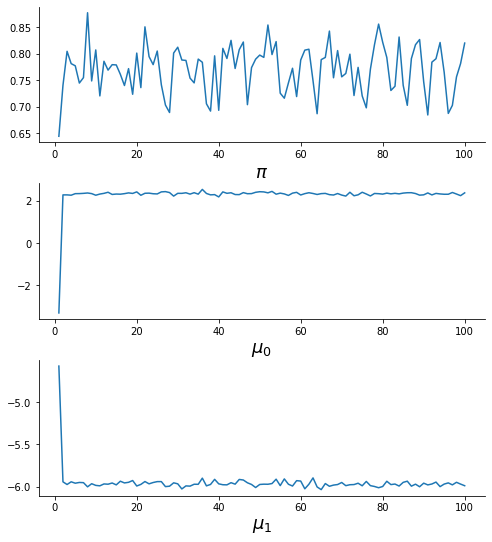

In [19]:
fig4, axs = plt.subplots(3, 1, figsize=(8,9))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
axs[0].plot(list(range(1,101)), trace["pi"])
axs[1].plot(list(range(1,101)), trace["mu"][:,0])
axs[2].plot(list(range(1,101)), trace["mu"][:,1])
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].spines['top'].set_visible(False)
axs[0].set_xlabel(rf"$\pi$")
axs[1].set_xlabel(rf"$\mu_{0}$")
axs[2].set_xlabel(rf"$\mu_{1}$")
plt.show()